In [ ]:
1、安装依赖。

In [1]:
!pip install -U langchain langchain-openai langgraph langsmith

  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.142
    Uninstalling langsmith-0.1.142:
      Successfully uninstalled langsmith-0.1.142
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.15
    Uninstalling langchain-core-0.3.15:
      Successfully uninstalled langchain-core-0.3.15
  Attempting uninstall: langgraph-checkpoint
    Found existing installation: langgraph-checkpoint 2.0.2
    Uninstalling langgraph-checkpoint-2.0.2:
      Successfully uninstalled langgraph-checkpoint-2.0.2
  Attempting uninstall: langchain-openai
    Found existing installation: langchain-openai 0.2.6
    Uninstalling langchain-openai-0.2.6:
      Successfully uninstalled langchain-openai-0.2.6
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.2.45
    Uninstalling langgraph-0.2.45:
      Successfully uninstalled langgraph-0.2.45


2、配置环境变量。

In [2]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "pr-best-artist-21"

os.environ["OPENAI_API_KEY"] = "sk-"
os.environ["OPENAI_API_BASE"] = ""

In [ ]:
3、定义llm model。

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()
llm.invoke("Hello, world!").content#test

'Hello! How can I assist you today?'

In [ ]:
4、定义工具。

In [4]:
import abc
from typing import Any
from datetime import datetime
from langchain.tools import BaseTool

class QueryTime(BaseTool, abc.ABC):
    name: str = "QueryTime"
    description: str = "用于查询当前日期、星期几及时间" 

    def __init__(self):
        super().__init__()

    async def _arun(self, *args: Any, **kwargs: Any) -> Any:
        # 用例中没有用到 arun，不予具体实现
        pass

    def _run(self, para) -> str:
        # 获取当前时间
        now = datetime.now()
        # 获取当前日期
        today = now.date()
        # 获取星期几的信息
        week_day = today.strftime("%A")
        # 将星期几的英文名称转换为中文
        week_day_zh = {
            "Monday": "星期一",
            "Tuesday": "星期二",
            "Wednesday": "星期三",
            "Thursday": "星期四",
            "Friday": "星期五",
            "Saturday": "星期六",
            "Sunday": "星期日",
        }.get(week_day, "未知")
        # 将日期格式化为字符串
        date_str = today.strftime("%Y年%m月%d日")
        # 将时间格式化为字符串
        time_str = now.strftime("%H:%M")

        return f"现在时间是：{time_str} {week_day_zh} {date_str}"

if __name__ == "__main__":
    tool = QueryTime()
    result = tool.run("")
    print(result)



现在时间是：16:12 星期日 2024年11月17日


In [5]:
from typing import Any

import requests
from langchain.tools import BaseTool
from urllib.parse import quote

class Weather(BaseTool):
    name: str = "weather"
    description: str = "此工具用于获取天气预报信息，需传入英文的城市名，参数格式：Guangzhou"

    def __init__(self):
        super().__init__()

    async def _arun(self, *args: Any, **kwargs: Any) -> Any:
        # 用例中没有用到 arun 不予具体实现
        pass


    def _run(self, para: str) -> str:
        try:
            if not para:
                return "参数不能为空"
            encoded_city = quote(para)

            api_url = f"http://api.openweathermap.org/data/2.5/weather?q={encoded_city}&appid=272fcb70d2c4e6f5134c2dce7d091df6"
            response = requests.get(api_url)
            if response.status_code == 200:
                weather_data = response.json()
              # 提取天气信息
                temperature_kelvin = weather_data['main']['temp']
                temperature_celsius = temperature_kelvin - 273.15
                min_temperature_kelvin = weather_data['main']['temp_min']
                max_temperature_kelvin = weather_data['main']['temp_max']
                min_temperature_celsius = min_temperature_kelvin - 273.15
                max_temperature_celsius = max_temperature_kelvin - 273.15
                description = weather_data['weather'][0]['description']
                wind_speed = weather_data['wind']['speed']

                # 构建天气描述
                weather_description = f"今天天气：{description}，气温：{temperature_celsius:.2f}摄氏度，风速：{wind_speed} m/s。"

                return f"天气预报信息：{weather_description}"
            else:
                return f"无法获取天气预报信息，状态码：{response.status_code}"
        except Exception as e:
            return f"发生错误：{str(e)}"


if __name__ == "__main__":
    weather_tool = Weather()
    weather_info = weather_tool.run("Guangzhou")
    print(weather_info)


天气预报信息：今天天气：broken clouds，气温：29.97摄氏度，风速：4.4 m/s。


5、创建agent graph。

In [12]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

memory = MemorySaver()
tools = [QueryTime(), Weather()]
agent_graph = create_react_agent(llm, tools, checkpointer=memory)

#memeory上用于分块
config = {"configurable": {"thread_id": "abc123"}}

6、查看agent graph。

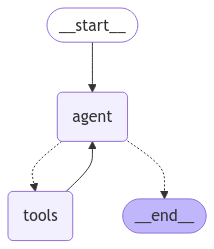

In [11]:
from IPython.display import Image, display

try:
    display(Image(agent_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

7、执行。

In [31]:
from langchain_core.messages import HumanMessage, SystemMessage
events = agent_graph.stream(
    {"messages": [SystemMessage("你的名字叫张三，18岁。"), HumanMessage(content="你好", name="User")]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        print(event["messages"][-1].content)

你好
你好，张三！有什么我可以帮助你的吗？如果你有任何问题或者想聊天，随时告诉我！


In [6]:

for chunk in agent_executor.stream(
    {"messages": [HumanMessage(content="还有吗", name="User")]}, {"configurable": {"thread_id": "abc123"}}
):
    print(chunk)
    if chunk.get("agent"):
        if chunk['agent']['messages'][0].content:
            print(chunk['agent']['messages'][0].content)
        else:
            print("现在调用{}工具".format(chunk['agent']['messages'][0].additional_kwargs['tool_calls'][0]['function']['name']))
        print("token使用：{}".format(chunk['agent']['messages'][0].response_metadata['token_usage']['total_tokens']))

    print("----")


{'agent': {'messages': [AIMessage(content='请问您具体想了解什么呢？我可以提供天气预报、时间日期等信息。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 89, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d54531d9eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-4ddeb38a-9300-440d-8138-c279fa2c5097-0', usage_metadata={'input_tokens': 89, 'output_tokens': 22, 'total_tokens': 111, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}}
请问您具体想了解什么呢？我可以提供天气预报、时间日期等信息。
token使用：111
----


8、测试记忆机制。

In [16]:
from langchain_core.messages import HumanMessage, AIMessage
snapshot = agent_executor.get_state(config)
existing_messages = snapshot.values["messages"]
existing_messages.append(HumanMessage(content="你叫什么名字？", name="User", create_at="2025-01-23"))
existing_messages.append(AIMessage("我叫fay"))
existing_messages#.pretty_print()

[HumanMessage(content='还有吗', additional_kwargs={}, response_metadata={}, name='User', id='f466081a-e840-42f7-ac2c-c9465dfe658d'),
 AIMessage(content='请问您具体想了解什么呢？我可以提供天气预报、时间日期等信息。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 89, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d54531d9eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-4ddeb38a-9300-440d-8138-c279fa2c5097-0', usage_metadata={'input_tokens': 89, 'output_tokens': 22, 'total_tokens': 111, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}),
 HumanMessage(content='你好吗', additional_kwargs={}, response_metadata={}, name='User'),
 AIMessage(content='你好吗', additional_

In [18]:
agent_executor.update_state(config, {"messages": existing_messages})

{'configurable': {'thread_id': 'abc123',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa4b9f-bff1-6823-8002-f65425e81a5d'}}

In [19]:
snapshot = agent_executor.get_state(config)
existing_messages = snapshot.values["messages"]
existing_messages

[HumanMessage(content='还有吗', additional_kwargs={}, response_metadata={}, name='User', id='f466081a-e840-42f7-ac2c-c9465dfe658d'),
 AIMessage(content='请问您具体想了解什么呢？我可以提供天气预报、时间日期等信息。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 89, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d54531d9eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-4ddeb38a-9300-440d-8138-c279fa2c5097-0', usage_metadata={'input_tokens': 89, 'output_tokens': 22, 'total_tokens': 111, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}),
 HumanMessage(content='你好吗', additional_kwargs={}, response_metadata={}, name='User', id='e509be56-3442-4648-ad9a-cee13bca82

In [14]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='还有吗', additional_kwargs={}, response_metadata={}, name='User', id='f466081a-e840-42f7-ac2c-c9465dfe658d'), AIMessage(content='请问您具体想了解什么呢？我可以提供天气预报、时间日期等信息。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 89, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d54531d9eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-4ddeb38a-9300-440d-8138-c279fa2c5097-0', usage_metadata={'input_tokens': 89, 'output_tokens': 22, 'total_tokens': 111, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}, next=(), config={'configurable': {'thread_id': 'abc123', 'checkpoint_ns': '', 'checkpoint

In [45]:
type(memory.get_tuple(config).checkpoint)

dict

In [50]:
memory.get_tuple(config).checkpoint

{'v': 1,
 'ts': '2024-11-15T08:21:08.671329+00:00',
 'id': '1efa32a9-0e5e-61cf-801f-fee8f6f6d005',
 'channel_values': {'messages': [HumanMessage(content='现在什么时间，广州天气怎么样', additional_kwargs={}, response_metadata={}, name='User', id='e26e51c3-2a22-4997-b8c4-c8354192aeea'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Sga9wIgaKZ8ZtZRzHvlIdbz1', 'function': {'arguments': '{"para": {}}', 'name': 'QueryTime'}, 'type': 'function'}, {'id': 'call_YyxTGWDjmKnRMLICROzdqBfe', 'function': {'arguments': '{"para": "Guangzhou"}', 'name': 'weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 94, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d54531d

In [44]:
memory.get_tuple(config).checkpoint['channel_values']['messages']

[HumanMessage(content='现在什么时间，广州天气怎么样', additional_kwargs={}, response_metadata={}, name='User', id='e26e51c3-2a22-4997-b8c4-c8354192aeea'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Sga9wIgaKZ8ZtZRzHvlIdbz1', 'function': {'arguments': '{"para": {}}', 'name': 'QueryTime'}, 'type': 'function'}, {'id': 'call_YyxTGWDjmKnRMLICROzdqBfe', 'function': {'arguments': '{"para": "Guangzhou"}', 'name': 'weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 94, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d54531d9eb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-366f5601-27ef-4238-8928-e7a74218a560-0', tool_calls=[{'name': 'QueryT

In [43]:
memory.get_tuple(config).checkpoint['channel_values']

{'messages': [HumanMessage(content='现在什么时间，广州天气怎么样', additional_kwargs={}, response_metadata={}, name='User', id='e26e51c3-2a22-4997-b8c4-c8354192aeea'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Sga9wIgaKZ8ZtZRzHvlIdbz1', 'function': {'arguments': '{"para": {}}', 'name': 'QueryTime'}, 'type': 'function'}, {'id': 'call_YyxTGWDjmKnRMLICROzdqBfe', 'function': {'arguments': '{"para": "Guangzhou"}', 'name': 'weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 94, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d54531d9eb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-366f5601-27ef-4238-8928-e7a74218a560-0', tool_calls=[{'